In [2]:
%pylab inline
import cosima_cookbook as cc
import numpy as np
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import scipy as sp
import pandas as pd
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import netCDF4 as nc
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import pylab
from matplotlib import ticker, cm
# for georefferenced data
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm # for colormap
from scipy import stats
from dask.distributed import Client, progress
import dask
#dask.config.set({'temporary_directory': '/g/data/e14/ss2778/data'})
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import h5py
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])
import cartopy.mpl.ticker as cticker

Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg', '025deg', '01deg']


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 41236:127.0.0.1:41236 vdi-n28.nci.org.au -l ss2778


Client Scheduler: tcp://127.0.0.1:45685 Dashboard: http://127.0.0.1:41236/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
aviso_clim_tstart = pd.to_datetime('1958', format='%Y')
aviso_clim_tend = aviso_clim_tstart + pd.DateOffset(years=60)
firstyear = pd.to_datetime(aviso_clim_tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(aviso_clim_tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('aviso_clim_tstart = ', aviso_clim_tstart)
print('aviso_clim_tend = ', aviso_clim_tend)

1958-2017
aviso_clim_tstart =  1958-01-01 00:00:00
aviso_clim_tend =  2018-01-01 00:00:00


In [6]:
x = (xr.open_mfdataset('/g/data1/ua8/JRA55-do/latest/slp.*.nc'))

In [7]:
df=x.sel(time=slice(aviso_clim_tstart,aviso_clim_tend))
slp=df.resample(time="M").mean()

In [8]:
slp

<xarray.Dataset>
Dimensions:    (latitude: 320, longitude: 640, time: 721)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-01-31
  * latitude   (latitude) float64 -89.57 -89.01 -88.45 ... 88.45 89.01 89.57
  * longitude  (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
Data variables:
    psl        (time, latitude, longitude) float32 dask.array<shape=(721, 320, 640), chunksize=(1, 320, 640)>

In [9]:
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
    
SSTm = cc.get_nc_variable(expt,'ocean_month.nc','surface_temp',n=n_files,time_units=time_units,offset=offset,use_cache=True)\
                                 .sel(time=slice(aviso_clim_tstart,aviso_clim_tend))- 273.15
SSTm.load();

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_surface_temp_-12_days-since-1718-01-01_-87658_False.pkl


In [10]:
SSTm

<xarray.DataArray 'surface_temp' (time: 720, yt_ocean: 300, xt_ocean: 360)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) datetime64[ns] 1958-01-17T12:00:00 ... 2017-12-16T12:00:00

In [11]:
# Load Nino 3.4 time series:
nino= SSTm.sel(xt_ocean=slice(-170,-120)).sel(yt_ocean=slice(-5,5))
SST_avg=nino.mean('xt_ocean').mean('yt_ocean')
Clim=SST_avg.groupby('time.month').mean('time')
out=SST_avg.groupby('time.month')
SSTa=(out-Clim)
Nino_nor= (SSTa-np.mean(SSTa))/np.std(SSTa)

In [12]:
slp_array=slp.to_array()

In [13]:
slp_array

<xarray.DataArray 'stack-dd1aa2c305d8077bf3c4db76c774b58f' (variable: 1, time: 721, latitude: 320, longitude: 640)>
dask.array<shape=(1, 721, 320, 640), dtype=float32, chunksize=(1, 1, 320, 640)>
Coordinates:
  * time       (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-01-31
  * latitude   (latitude) float64 -89.57 -89.01 -88.45 ... 88.45 89.01 89.57
  * longitude  (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
  * variable   (variable) <U3 'psl'

In [14]:
SLP=slp_array[:,0:720,:,:]
slp_sq=np.squeeze(SLP)

In [16]:
slp_sq

<xarray.DataArray 'stack-dd1aa2c305d8077bf3c4db76c774b58f' (time: 720, latitude: 320, longitude: 640)>
dask.array<shape=(720, 320, 640), dtype=float32, chunksize=(1, 320, 640)>
Coordinates:
  * time       (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2017-12-31
  * latitude   (latitude) float64 -89.57 -89.01 -88.45 ... 88.45 89.01 89.57
  * longitude  (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    variable   <U3 'psl'

In [19]:
t = len(Nino_nor) # length of nino34 time series
slp_reg = np.empty((t, 320, 640)) # empty array 

for i in range(1,t): # loop over time dimension
    slp_reg[i,:,:] = slp_sq[i,:,:] * Nino_nor[i] # regression here
    if i%100 == 0: # modulo function
        print(i) # print every 10th iteration

100
200
300
400


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

500


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

600


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

700


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


In [26]:
ds = xr.Dataset({'slp_reg': (('time', 'latitude', 'longitude'), slp_reg)})
reg=ds.slp_reg.mean('time')

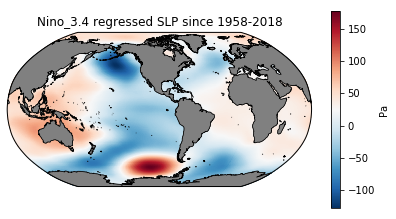

In [38]:
#SLP regression Plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(slp_sq.longitude,slp_sq.latitude)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)
    
ax = plt.subplot(2,2,1,projection=ccrs.Robinson(central_longitude=-100))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
#gl = ax.gridlines(draw_labels=False)
h=plt.pcolormesh(X,Y,reg,cmap='RdBu_r',transform=ccrs.PlateCarree())
cb = plt.colorbar(h,orientation='vertical',label='Pa')
#plt.contour(X,Y,reg,levels=5, linewidths=0.5, colors='k')
plt.title('Nino_3.4 regressed SLP since 1958-2018')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('Regressed SLP_1958-2018')

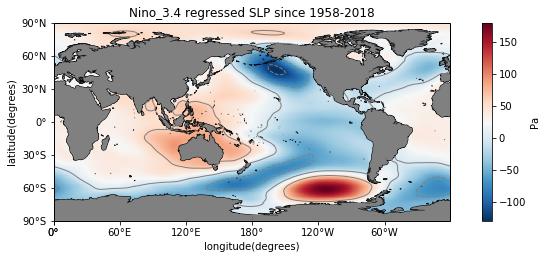

In [43]:
#SLP regression Plot
plt.figure(figsize=(25,8))
X,Y=np.meshgrid(slp_sq.longitude,slp_sq.latitude)
#adding geometry
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',facecolor='gray',linewidth=0.1)   
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())   
ax.set_yticks([-90,-60,-30,0,30,60,90], crs=ccrs.PlateCarree())
ax.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter();
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
ax.yaxis.set_major_formatter(lat_formatter) # "       "       "
    # ax.grid(linewidth=.5, color='grey', alpha=0.5) # grid specifics
#ax.xaxis.label.set_visible(False) # only labels on left & bottom
#ax.yaxis.label.set_visible(False)
h=plt.pcolormesh(X,Y,reg,cmap='RdBu_r',transform=ccrs.PlateCarree()) # Ploting slp
plt.contour(X,Y,reg,levels = np.arange(-120.,120.,60),      #Plotting contour
                            linewidths=1.0, colors='grey',
                            transform=ccrs.PlateCarree())
plt.colorbar(h,orientation='vertical',label='Pa') #making colorbar
plt.title('Nino_3.4 regressed SLP since 1958-2018')
ax.set_ylabel('latitude(degrees)')
ax.set_xlabel('longitude(degrees)')
savefigure('Regressed SLP_1958-2018_2')